## Introduction
Overview
This notebook outlines the pipeline for predicting early hospital readmission for diabetic patients. The process includes:

Importing libraries

Loading data

Preprocessing and feature engineering

Exploratory Data Analysis (EDA)

Model training and evaluation

Conclusions



In [54]:
# Imported necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

## Fetching and Loading the Data


Data Acquisition
This cell fetches the diabetes dataset using the fetch_ucirepo function. If a local pickle file exists, it is loaded instead.



In [55]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
diabetes_data = fetch_ucirepo(id=296)

/usr/local/lib/python3.11/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


## Data Preparation and Feature Engineering


 Creating Feature and Target DataFrames


In [57]:
# data (as pandas dataframes)
features = diabetes_data.data.features.copy(deep=True)
target = diabetes_data.data.targets.copy(deep=True)

In [58]:
# Target values of the data
target['readmitted'].unique()

array(['NO', '>30', '<30'], dtype=object)

In [59]:
# Only considering patients with <30 days are counted as being readmitted
target['readmitted'] = target['readmitted'].replace({'NO': 0, '>30': 0, '<30': 1})
target.value_counts()

<ipython-input-59-90d882a26672>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target['readmitted'] = target['readmitted'].replace({'NO': 0, '>30': 0, '<30': 1})


,count
readmitted,
0,90409
1,11357


In [60]:
# Converting age ranges into mid point of range for each record
for i in range(10):
    features['age'] = features['age'].replace(f'[{str(10*i)}-{10*(i+1)})', 10*i+5)
features

<ipython-input-60-90ff83b6bb1c>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features['age'] = features['age'].replace(f'[{str(10*i)}-{10*(i+1)})', 10*i+5)


,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,Caucasian,Female,5,NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,No
1,Caucasian,Female,15,NaN,1,1,7,3,NaN,NaN,...,No,No,Up,No,No,No,No,No,Ch,Yes
2,AfricanAmerican,Female,25,NaN,1,1,7,2,NaN,NaN,...,No,No,No,No,No,No,No,No,No,Yes
3,Caucasian,Male,35,NaN,1,1,7,2,NaN,NaN,...,No,No,Up,No,No,No,No,No,Ch,Yes
4,Caucasian,Male,45,NaN,1,1,7,1,NaN,NaN,...,No,No,Steady,No,No,No,No,No,Ch,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,75,NaN,1,3,7,3,MC,NaN,...,No,No,Down,No,No,No,No,No,Ch,Yes
101762,AfricanAmerican,Female,85,NaN,1,4,5,5,MC,NaN,...,No,No,Steady,No,No,No,No,No,No,Yes
101763,Caucasian,Male,75,NaN,1,1,7,1,MC,NaN,...,No,No,Down,No,No,No,No,No,Ch,Yes
101764,Caucasian,Female,85,NaN,2,3,7,10,MC,Surgery-General,...,No,No,Up,No,No,No,No,No,Ch,Yes


In [61]:
# Printing columns with the number of missing values and percentage.
print('Columns with number of missing values and percentage:')
s = pd.Series(features.isna().sum())
for i in range(len(s.index)):
    if s.iloc[i]:
        print(f'{s.index[i]}: {s.iloc[i]} {100 * s.iloc[i] / len(features):.2f}%')

Columns with number of missing values and percentage:
race: 2273 2.23%
weight: 98569 96.86%
payer_code: 40256 39.56%
medical_specialty: 49949 49.08%
diag_1: 21 0.02%
diag_2: 358 0.35%
diag_3: 1423 1.40%
max_glu_serum: 96420 94.75%
A1Cresult: 84748 83.28%


In [62]:
# Since max_glu_serum and A1Cresult has NaN values if test wasn't taken, we don't drop them
# Weight could be significant but there are too many missing values, we will drop it
# payer_code and medical_speciality don't impact the target so we can drop it
columns = ['weight', 'payer_code', 'medical_specialty']
features = features.drop(columns=columns)
features

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,Caucasian,Female,5,6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,No
1,Caucasian,Female,15,1,1,7,3,59,0,18,...,No,No,Up,No,No,No,No,No,Ch,Yes
2,AfricanAmerican,Female,25,1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,No,Yes
3,Caucasian,Male,35,1,1,7,2,44,1,16,...,No,No,Up,No,No,No,No,No,Ch,Yes
4,Caucasian,Male,45,1,1,7,1,51,0,8,...,No,No,Steady,No,No,No,No,No,Ch,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,75,1,3,7,3,51,0,16,...,No,No,Down,No,No,No,No,No,Ch,Yes
101762,AfricanAmerican,Female,85,1,4,5,5,33,3,18,...,No,No,Steady,No,No,No,No,No,No,Yes
101763,Caucasian,Male,75,1,1,7,1,53,0,9,...,No,No,Down,No,No,No,No,No,Ch,Yes
101764,Caucasian,Female,85,2,3,7,10,45,2,21,...,No,No,Up,No,No,No,No,No,Ch,Yes


In [63]:
#Check data for columns with same values that will not affect model performance
unique_features = []
for i in features.columns:
    if len(features[i].unique()) == 1:
        print(f'{i}: {features[i].unique()}')
        unique_features.append(i)
features = features.drop(columns=unique_features)
features

examide: ['No']
citoglipton: ['No']


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,Caucasian,Female,5,6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,No
1,Caucasian,Female,15,1,1,7,3,59,0,18,...,No,No,Up,No,No,No,No,No,Ch,Yes
2,AfricanAmerican,Female,25,1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,No,Yes
3,Caucasian,Male,35,1,1,7,2,44,1,16,...,No,No,Up,No,No,No,No,No,Ch,Yes
4,Caucasian,Male,45,1,1,7,1,51,0,8,...,No,No,Steady,No,No,No,No,No,Ch,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,75,1,3,7,3,51,0,16,...,No,No,Down,No,No,No,No,No,Ch,Yes
101762,AfricanAmerican,Female,85,1,4,5,5,33,3,18,...,No,No,Steady,No,No,No,No,No,No,Yes
101763,Caucasian,Male,75,1,1,7,1,53,0,9,...,No,No,Down,No,No,No,No,No,Ch,Yes
101764,Caucasian,Female,85,2,3,7,10,45,2,21,...,No,No,Up,No,No,No,No,No,Ch,Yes


In [64]:
# Only consider primary diagnosis diag_1, ignore diag_2 and diag_3
# Also drop rows with missing values of diag_1, race and gender
features = features.drop(columns=['diag_2', 'diag_3'])
features = features.dropna(subset=['race', 'gender', 'diag_1'])
features

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,Caucasian,Female,5,6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,No
1,Caucasian,Female,15,1,1,7,3,59,0,18,...,No,No,Up,No,No,No,No,No,Ch,Yes
2,AfricanAmerican,Female,25,1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,No,Yes
3,Caucasian,Male,35,1,1,7,2,44,1,16,...,No,No,Up,No,No,No,No,No,Ch,Yes
4,Caucasian,Male,45,1,1,7,1,51,0,8,...,No,No,Steady,No,No,No,No,No,Ch,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,75,1,3,7,3,51,0,16,...,No,No,Down,No,No,No,No,No,Ch,Yes
101762,AfricanAmerican,Female,85,1,4,5,5,33,3,18,...,No,No,Steady,No,No,No,No,No,No,Yes
101763,Caucasian,Male,75,1,1,7,1,53,0,9,...,No,No,Down,No,No,No,No,No,Ch,Yes
101764,Caucasian,Female,85,2,3,7,10,45,2,21,...,No,No,Up,No,No,No,No,No,Ch,Yes


In [65]:
# discharge_disposition_id represents where patient went after hospitalization
# values of 11, 13, 14, 19, 20, 21 are related to death or hospice and do not affect readmittance so we can drop rows with these values
# setting new column of discharge_disposition where value is home if 1 and other if otherwise
features = features[~features['discharge_disposition_id'].astype(str).isin(['11', '13', '14', '19', '20', '21'])]
features['discharge_disposition'] = features['discharge_disposition_id'].apply(lambda x: 'home' if str(x) == 1 else 'other')
discharge_dummies = pd.get_dummies(features['discharge_disposition'], prefix='discharge', dtype=int)
features = pd.concat([features, discharge_dummies], axis=1)
features = features.drop(columns=['discharge_disposition_id'])
features

<ipython-input-65-59b9093f02f4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['discharge_disposition'] = features['discharge_disposition_id'].apply(lambda x: 'home' if str(x) == 1 else 'other')


,race,gender,age,admission_type_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,discharge_disposition,discharge_other
0,Caucasian,Female,5,6,1,1,41,0,1,0,...,No,No,No,No,No,No,No,No,other,1
1,Caucasian,Female,15,1,7,3,59,0,18,0,...,Up,No,No,No,No,No,Ch,Yes,other,1
2,AfricanAmerican,Female,25,1,7,2,11,5,13,2,...,No,No,No,No,No,No,No,Yes,other,1
3,Caucasian,Male,35,1,7,2,44,1,16,0,...,Up,No,No,No,No,No,Ch,Yes,other,1
4,Caucasian,Male,45,1,7,1,51,0,8,0,...,Steady,No,No,No,No,No,Ch,Yes,other,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,75,1,7,3,51,0,16,0,...,Down,No,No,No,No,No,Ch,Yes,other,1
101762,AfricanAmerican,Female,85,1,5,5,33,3,18,0,...,Steady,No,No,No,No,No,No,Yes,other,1
101763,Caucasian,Male,75,1,7,1,53,0,9,1,...,Down,No,No,No,No,No,Ch,Yes,other,1
101764,Caucasian,Female,85,2,7,10,45,2,21,0,...,Up,No,No,No,No,No,Ch,Yes,other,1


In [66]:
# changing admission_type_id to admission_type which has 9 values representing emergency, urgent, elective, newborn, etc.
# collapsing types 2 and 7 to type 1 and types 6 and 8 to 5
def adm_type_filter(x):
    if x in [2, 7]: return 1
    elif x in [6, 8]: return 5
    else: return x

features['admission_type'] = features['admission_type_id'].apply(adm_type_filter)
mapping = {1: 'emergency', 3: 'elective', 4: 'newborn', 5: 'other'}
features['admission_type'] = features['admission_type'].map(mapping)
admission_dummies = pd.get_dummies(features['admission_type'], prefix='admission', dtype=int)
features = pd.concat([features, admission_dummies], axis=1)
features = features.drop(columns=['admission_type_id'])
features

,race,gender,age,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,metformin-pioglitazone,change,diabetesMed,discharge_disposition,discharge_other,admission_type,admission_elective,admission_emergency,admission_newborn,admission_other
0,Caucasian,Female,5,1,1,41,0,1,0,0,...,No,No,No,other,1,other,0,0,0,1
1,Caucasian,Female,15,7,3,59,0,18,0,0,...,No,Ch,Yes,other,1,emergency,0,1,0,0
2,AfricanAmerican,Female,25,7,2,11,5,13,2,0,...,No,No,Yes,other,1,emergency,0,1,0,0
3,Caucasian,Male,35,7,2,44,1,16,0,0,...,No,Ch,Yes,other,1,emergency,0,1,0,0
4,Caucasian,Male,45,7,1,51,0,8,0,0,...,No,Ch,Yes,other,1,emergency,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,75,7,3,51,0,16,0,0,...,No,Ch,Yes,other,1,emergency,0,1,0,0
101762,AfricanAmerican,Female,85,5,5,33,3,18,0,0,...,No,No,Yes,other,1,emergency,0,1,0,0
101763,Caucasian,Male,75,7,1,53,0,9,1,0,...,No,Ch,Yes,other,1,emergency,0,1,0,0
101764,Caucasian,Female,85,7,10,45,2,21,0,0,...,No,Ch,Yes,other,1,emergency,0,1,0,0


In [67]:
# change column admission_source_id to admission_source
# collapsing 21 distinct values to general meaning: (1, 2, 3): Physician Referral,
# (4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26): Other, remaining values: Emergency Room
def collapse_adm_source(x):
    if x in [1, 2, 3]: return 'physician referral'
    elif x in [4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]: return 'other'
    else: return 'emergency room'

features['admission_source'] = features['admission_source_id'].apply(collapse_adm_source)
source_dummies = pd.get_dummies(features['admission_source'], prefix='source', dtype=int)
features = pd.concat([features, source_dummies], axis=1)
features = features.drop(columns=['admission_source_id'])
features

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,discharge_other,admission_type,admission_elective,admission_emergency,admission_newborn,admission_other,admission_source,source_emergency room,source_other,source_physician referral
0,Caucasian,Female,5,1,41,0,1,0,0,0,...,1,other,0,0,0,1,physician referral,0,0,1
1,Caucasian,Female,15,3,59,0,18,0,0,0,...,1,emergency,0,1,0,0,emergency room,1,0,0
2,AfricanAmerican,Female,25,2,11,5,13,2,0,1,...,1,emergency,0,1,0,0,emergency room,1,0,0
3,Caucasian,Male,35,2,44,1,16,0,0,0,...,1,emergency,0,1,0,0,emergency room,1,0,0
4,Caucasian,Male,45,1,51,0,8,0,0,0,...,1,emergency,0,1,0,0,emergency room,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,75,3,51,0,16,0,0,0,...,1,emergency,0,1,0,0,emergency room,1,0,0
101762,AfricanAmerican,Female,85,5,33,3,18,0,0,1,...,1,emergency,0,1,0,0,other,0,1,0
101763,Caucasian,Male,75,1,53,0,9,1,0,0,...,1,emergency,0,1,0,0,emergency room,1,0,0
101764,Caucasian,Female,85,10,45,2,21,0,0,1,...,1,emergency,0,1,0,0,emergency room,1,0,0


## Mapping ICD-9 Diagnosis Codes to Disease Categories

The following function, `map_diag`, maps primary diagnosis codes (ICD-9) to specific disease categories.  
- **Codes starting with `E` or `V`**: These are non-numeric ICD-9 codes and are classified as "Other".  
- **Numeric codes**: After converting the code to a float, the function maps specific ranges to categories such as "Diabetes", "Circulatory", "Respiratory", etc.  

After mapping the diagnosis codes, the code applies this function to the `diag_1` column, creates one-hot encoded (dummy) variables for each disease category, and then drops the original diagnosis column.


In [68]:
# primary diagnosis diag_1 refers to code on ICD-9 type
def map_diag(code):
    if isinstance(code, str) and code[0] in ['E', 'V']:
        return 'Other'
    num = float(code)
    if str(num).startswith('250'):
        return 'Diabetes'
    elif 390 <= num <= 459 or num == 785:
        return "Circulatory"
    elif 460 <= num <= 519 or num == 786:
        return "Respiratory"
    elif 520 <= num <= 579 or num == 787:
        return "Digestive"
    elif 800 <= num <= 999:
        return "Injury"
    elif 710 <= num <= 739:
        return "Musculoskeletal"
    elif 580 <= num <= 629 or num == 788:
        return "Genitourinary"
    elif 140 <= num <= 239:
        return "Neoplasms"
    else:
        return "Other"

features['disease'] = features['diag_1'].apply(map_diag)
disease_dummies = pd.get_dummies(features['disease'], prefix='diag', dtype=int)
features = pd.concat([features, disease_dummies], axis=1)
features = features.drop(columns=['diag_1'])
features

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,disease,diag_Circulatory,diag_Diabetes,diag_Digestive,diag_Genitourinary,diag_Injury,diag_Musculoskeletal,diag_Neoplasms,diag_Other,diag_Respiratory
0,Caucasian,Female,5,1,41,0,1,0,0,0,...,Diabetes,0,1,0,0,0,0,0,0,0
1,Caucasian,Female,15,3,59,0,18,0,0,0,...,Other,0,0,0,0,0,0,0,1,0
2,AfricanAmerican,Female,25,2,11,5,13,2,0,1,...,Other,0,0,0,0,0,0,0,1,0
3,Caucasian,Male,35,2,44,1,16,0,0,0,...,Other,0,0,0,0,0,0,0,1,0
4,Caucasian,Male,45,1,51,0,8,0,0,0,...,Neoplasms,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,75,3,51,0,16,0,0,0,...,Diabetes,0,1,0,0,0,0,0,0,0
101762,AfricanAmerican,Female,85,5,33,3,18,0,0,1,...,Digestive,0,0,1,0,0,0,0,0,0
101763,Caucasian,Male,75,1,53,0,9,1,0,0,...,Other,0,0,0,0,0,0,0,1,0
101764,Caucasian,Female,85,10,45,2,21,0,0,1,...,Injury,0,0,0,0,1,0,0,0,0


In [69]:
# Check for missing values in gender column and convert column for binary encoding
features = features[features['gender'].isin(['Male', 'Female'])]
features['gender'] = (features['gender'] == 'Male').astype(int)
features

<ipython-input-69-b5bf3e0d9163>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['gender'] = (features['gender'] == 'Male').astype(int)


,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,disease,diag_Circulatory,diag_Diabetes,diag_Digestive,diag_Genitourinary,diag_Injury,diag_Musculoskeletal,diag_Neoplasms,diag_Other,diag_Respiratory
0,Caucasian,0,5,1,41,0,1,0,0,0,...,Diabetes,0,1,0,0,0,0,0,0,0
1,Caucasian,0,15,3,59,0,18,0,0,0,...,Other,0,0,0,0,0,0,0,1,0
2,AfricanAmerican,0,25,2,11,5,13,2,0,1,...,Other,0,0,0,0,0,0,0,1,0
3,Caucasian,1,35,2,44,1,16,0,0,0,...,Other,0,0,0,0,0,0,0,1,0
4,Caucasian,1,45,1,51,0,8,0,0,0,...,Neoplasms,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,1,75,3,51,0,16,0,0,0,...,Diabetes,0,1,0,0,0,0,0,0,0
101762,AfricanAmerican,0,85,5,33,3,18,0,0,1,...,Digestive,0,0,1,0,0,0,0,0,0
101763,Caucasian,1,75,1,53,0,9,1,0,0,...,Other,0,0,0,0,0,0,0,1,0
101764,Caucasian,0,85,10,45,2,21,0,0,1,...,Injury,0,0,0,0,1,0,0,0,0


## Counting the Number of Medication Changes

This section calculates how many times a patient's diabetes medications were changed during their hospital stay.  
Each medication column in the dataset contains values like:
- `'No'` → The medication was not prescribed.
- `'Steady'` → The medication was continued without changes.
- `'Up'` or `'Down'` → The dosage was changed.

To quantify how many medications were changed (increased or decreased), we:
1. Convert each medication column into a binary temporary column, where:
   - `0` means no change (`'No'` or `'Steady'`)
   - `1` means a change occurred (`'Up'` or `'Down'`)
2. Sum the temporary columns row-wise to compute the total number of medication changes per patient.
3. Store the result in a new column: `numchange`.


In [70]:
# No. of times medicine has been changed

medicines = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone',
       'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin',
       'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

for col in medicines:
    colname = str(col) + '_temp'
    features[colname] = features[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)

features['numchange'] = 0
for col in medicines:
    colname = str(col) + '_temp'
    features['numchange'] = features['numchange'] + features[colname]
    del features[colname]

features['numchange'].value_counts()

<ipython-input-70-640a440c841a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[colname] = features[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
<ipython-input-70-640a440c841a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[colname] = features[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
<ipython-input-70-640a440c841a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,count
numchange,
0,70617
1,25083
2,1279
3,106
4,5


## Encoding Categorical Features: `change` and `diabetesMed`

To prepare the data for machine learning models, categorical features must be converted to numeric form.

In this step:
- The `change` column, which indicates whether the patient's medication was changed during the encounter (`'Ch'` = Change, `'No'` = No Change), is encoded as:
  - `1` for `'Ch'`
  - `0` for `'No'`
  
- The `diabetesMed` column indicates whether the patient was prescribed any diabetes medication:
  - `1` for `'Yes'`
  - `0` for `'No'`

This transformation makes both columns numerical and suitable for modeling.


In [71]:
features['change'] = features['change'].replace({'Ch': 1, 'No': 0})
features['diabetesMed'] = features['diabetesMed'].replace({'Yes': 1, 'No': 0})
features

<ipython-input-71-44d100dbdd4d>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features['change'] = features['change'].replace({'Ch': 1, 'No': 0})
<ipython-input-71-44d100dbdd4d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['change'] = features['change'].replace({'Ch': 1, 'No': 0})
<ipython-input-71-44d100dbdd4d>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,diag_Circulatory,diag_Diabetes,diag_Digestive,diag_Genitourinary,diag_Injury,diag_Musculoskeletal,diag_Neoplasms,diag_Other,diag_Respiratory,numchange
0,Caucasian,0,5,1,41,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,Caucasian,0,15,3,59,0,18,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,AfricanAmerican,0,25,2,11,5,13,2,0,1,...,0,0,0,0,0,0,0,1,0,0
3,Caucasian,1,35,2,44,1,16,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,Caucasian,1,45,1,51,0,8,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,1,75,3,51,0,16,0,0,0,...,0,1,0,0,0,0,0,0,0,1
101762,AfricanAmerican,0,85,5,33,3,18,0,0,1,...,0,0,1,0,0,0,0,0,0,0
101763,Caucasian,1,75,1,53,0,9,1,0,0,...,0,0,0,0,0,0,0,1,0,1
101764,Caucasian,0,85,10,45,2,21,0,0,1,...,0,0,0,0,1,0,0,0,0,1


## Encoding Lab Results: `A1Cresult` and `max_glu_serum`

In this section, we transform lab test results into numerical scores for further analysis or modeling. The two columns of interest are:

- **`A1Cresult`**: Reflects the patient's glycated hemoglobin (HbA1c) levels.
- **`max_glu_serum`**: Represents the maximum glucose serum measurement during the patient encounter.

### Scoring System:
- **Abnormal values** (indicative of poor diabetes control) are given a weight of **1**:
  - `>7`, `>8` for A1C
  - `>200`, `>300` for glucose serum
- **Normal values** are given a weight of **0**: `'Norm'`
- **Tests not performed** (e.g., `'None'`) are assigned **-99** to indicate missing or unavailable data.


In [72]:
# For A1Cresult, values of >7 and >8 are abnormal and are weighted 1, norm is normal does and weighted 0 and the rest None are not tested and weighted -99
# Similarly for max_glu_serum with values of >200 and > 300 being abnormal
def filter_A1Cresult(x):
    if x in ['>7', '>8']: return 1
    elif x == 'Norm': return 0
    else: return -99

def filter_max_glu_serum(x):
    if x in ['>200', '>300']: return 1
    elif x == 'Norm': return 0
    else: return -99

features['A1Cresult'] = features['A1Cresult'].apply(filter_A1Cresult)
features['max_glu_serum'] = features['max_glu_serum'].apply(filter_max_glu_serum)
features

<ipython-input-72-424bfbb820f2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['A1Cresult'] = features['A1Cresult'].apply(filter_A1Cresult)
<ipython-input-72-424bfbb820f2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['max_glu_serum'] = features['max_glu_serum'].apply(filter_max_glu_serum)


,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,diag_Circulatory,diag_Diabetes,diag_Digestive,diag_Genitourinary,diag_Injury,diag_Musculoskeletal,diag_Neoplasms,diag_Other,diag_Respiratory,numchange
0,Caucasian,0,5,1,41,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,Caucasian,0,15,3,59,0,18,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,AfricanAmerican,0,25,2,11,5,13,2,0,1,...,0,0,0,0,0,0,0,1,0,0
3,Caucasian,1,35,2,44,1,16,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,Caucasian,1,45,1,51,0,8,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,1,75,3,51,0,16,0,0,0,...,0,1,0,0,0,0,0,0,0,1
101762,AfricanAmerican,0,85,5,33,3,18,0,0,1,...,0,0,1,0,0,0,0,0,0,0
101763,Caucasian,1,75,1,53,0,9,1,0,0,...,0,0,0,0,0,0,0,1,0,1
101764,Caucasian,0,85,10,45,2,21,0,0,1,...,0,0,0,0,1,0,0,0,0,1


## Encoding Medication Usage for Modeling

To improve model performance, it's essential to convert categorical values into numerical form.  
In this section, we encode **diabetes-related medication columns** to represent whether a medication was administered or adjusted.

### Original Medication Values:
- `'No'` → The drug was **not prescribed**
- `'Steady'`, `'Up'`, `'Down'` → The drug was **prescribed** and possibly adjusted

### Encoding Strategy:
- `'No'` → **0**
- `'Steady'`, `'Up'`, `'Down'` → **1**

This binary representation captures whether a patient was treated with each medication, regardless of whether the dosage changed.

In [73]:
# For better fit in our model, we will encode the values for the medicines
# Steady, Up and Down values are changes in the dose and are values 1 while No is 0
def filter_drug(x):
    if x == 'No': return 0
    else: return 1

for col in medicines:
    features[col] = features[col].apply(filter_drug)
features

<ipython-input-73-15d189f2d3d9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[col] = features[col].apply(filter_drug)


,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,diag_Circulatory,diag_Diabetes,diag_Digestive,diag_Genitourinary,diag_Injury,diag_Musculoskeletal,diag_Neoplasms,diag_Other,diag_Respiratory,numchange
0,Caucasian,0,5,1,41,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,Caucasian,0,15,3,59,0,18,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,AfricanAmerican,0,25,2,11,5,13,2,0,1,...,0,0,0,0,0,0,0,1,0,0
3,Caucasian,1,35,2,44,1,16,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,Caucasian,1,45,1,51,0,8,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,1,75,3,51,0,16,0,0,0,...,0,1,0,0,0,0,0,0,0,1
101762,AfricanAmerican,0,85,5,33,3,18,0,0,1,...,0,0,1,0,0,0,0,0,0,0
101763,Caucasian,1,75,1,53,0,9,1,0,0,...,0,0,0,0,0,0,0,1,0,1
101764,Caucasian,0,85,10,45,2,21,0,0,1,...,0,0,0,0,1,0,0,0,0,1


In [74]:
print('Distibution of Race:')
print(features['race'].value_counts(normalize=True) * 100)

Distibution of Race:
race
Caucasian          76.437326
AfricanAmerican    19.325368
Hispanic            2.075394
Other               1.515089
Asian               0.646823
Name: proportion, dtype: float64


## Grouping and Encoding Race Feature

The `race` column contains various categories, but two—**Caucasian** and **African-American**—have significantly more data than others.  
To simplify the modeling process and avoid sparse dummy columns, we group the less represented races into a single category called **'Other'**.

### Steps:
1. Reclassify `'Asian'` and `'Hispanic'` into `'Other'`.
2. Use one-hot encoding (`pd.get_dummies`) to convert the categorical `race` column into binary columns.
3. Concatenate the encoded columns with the original dataset.

This allows the model to interpret race as multiple binary features while reducing noise from underrepresented groups.


In [75]:
# Since caucasian and african-american have significantly more data, we will group the other races as one class
map_race = {'Asian': 'Other', 'Hispanic': 'Other'}
features['race'] = features['race'].replace(map_race)
race_dummies = pd.get_dummies(features['race'], dtype=int)
features = pd.concat([features, race_dummies], axis=1)
features

<ipython-input-75-91ef9ad78bf1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['race'] = features['race'].replace(map_race)


,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,diag_Genitourinary,diag_Injury,diag_Musculoskeletal,diag_Neoplasms,diag_Other,diag_Respiratory,numchange,AfricanAmerican,Caucasian,Other
0,Caucasian,0,5,1,41,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,Caucasian,0,15,3,59,0,18,0,0,0,...,0,0,0,0,1,0,1,0,1,0
2,AfricanAmerican,0,25,2,11,5,13,2,0,1,...,0,0,0,0,1,0,0,1,0,0
3,Caucasian,1,35,2,44,1,16,0,0,0,...,0,0,0,0,1,0,1,0,1,0
4,Caucasian,1,45,1,51,0,8,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,1,75,3,51,0,16,0,0,0,...,0,0,0,0,0,0,1,1,0,0
101762,AfricanAmerican,0,85,5,33,3,18,0,0,1,...,0,0,0,0,0,0,0,1,0,0
101763,Caucasian,1,75,1,53,0,9,1,0,0,...,0,0,0,0,1,0,1,0,1,0
101764,Caucasian,0,85,10,45,2,21,0,0,1,...,0,1,0,0,0,0,1,0,1,0


## Feature Classification and Engineering

In this section, we:
1. Separate features into **numerical** and **categorical** groups for later preprocessing or modeling.
2. Manually define key numerical and categorical columns based on domain knowledge and dataset structure.
3. Engineer a new feature called **`service_util`**, which represents a patient's overall healthcare service usage by summing:
   - Number of **outpatient visits**
   - Number of **inpatient visits**
   - Number of **emergency visits**

This feature may serve as a proxy for the severity or frequency of patient interactions with the healthcare system.


In [76]:
features.select_dtypes(include='number').columns

Index(['gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'discharge_other',
       'admission_elective', 'admission_emergency', 'admission_newborn',
       'admission_other', 'source_emergency room', 'source_other',
       'source_physician referral', 'diag_Circulatory', 'diag_Diabetes',
       'diag_Digestive', 'diag_Genitourinary', 'diag_Injury',
       'diag_Musculoskeletal', 'diag_Neoplasm

In [77]:
features.select_dtypes(include='object').columns

Index(['race', 'discharge_disposition', 'admission_type', 'admission_source',
       'disease'],
      dtype='object')

In [78]:
numerical_columns = ['num_medications', 'num_lab_procedures', 'num_procedures',
                     'number_outpatient', 'number_emergency', 'number_inpatient',
                     'number_diagnoses', 'time_in_hospital']
categorical_columns = ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed',
       'discharge_disposition', 'admission_type', 'admission_source']
len(categorical_columns)

31

In [79]:
features.columns

Index(['race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed',
       'discharge_disposition', 'discharge_other', 'admission_type',
       'admission_elective', 'admission_emergency', 'admission_newborn',
       'admission_other', 'admission_source', 'source_emergency room',
       'source_other', 'source_physician referral', 'disease',
       'diag_Circulatory', 'diag_Diabetes', 'diag_Diges

In [80]:
features['service_util'] = features['number_outpatient'] + features['number_inpatient'] + features['number_emergency']

## Exploratory Data Analysis (EDA): Readmission Insights

In this section, we perform a thorough analysis to uncover patterns and correlations related to hospital readmissions. The primary goal is to understand how different patient attributes and healthcare factors relate to the likelihood of being readmitted.

### Target Variable: `readmitted`
This binary variable indicates whether a patient was readmitted to the hospital:
- `0` — Patient was **not readmitted**.
- `1` — Patient was **readmitted**.

---

### 1. Distribution of Readmission
We begin by visualizing the distribution of readmitted vs. non-readmitted patients using a count plot. This helps us determine if the dataset is balanced or if it exhibits class imbalance (i.e., more patients in one category than the other).

### 2. Readmission by Race
Next, we examine how readmission is distributed across different racial groups. This can uncover any disparities in outcomes among racial demographics. The count plot shows both the overall population for each race and the share that was readmitted.

### 3. Length of Stay vs. Readmission
We use a Kernel Density Estimate (KDE) plot to compare the distribution of `time_in_hospital` for both readmitted and non-readmitted groups. This allows us to:
- Observe whether patients who stayed longer tend to get readmitted.
- Identify overlap in distributions or significant differences in their shapes.

### 4. Age vs. Readmission
Using a horizontal count plot, we visualize the age distribution of patients and highlight how readmission frequency varies across age brackets. This helps identify whether certain age groups are more at risk of readmission.

---

### 5. Numerical Feature Analysis
We consolidate key numerical features to analyze their distributions and relationships.

#### Selected Numerical Columns:
- `num_medications`
- `num_lab_procedures`
- `num_procedures`
- `number_outpatient`
- `number_emergency`
- `number_inpatient`
- `number_diagnoses`
- `time_in_hospital`
- `age` (encoded numerically)
- `gender` (encoded numerically)
- `numchange` (number of medications changed)
- `service_util` (sum of outpatient, emergency, and inpatient visits)

These features are plotted using boxplots to:
- Compare their ranges and medians.
- Detect skewed distributions and outliers.

We generate boxplots twice:
1. **With outliers** to see natural variation.
2. **Without outliers** by filtering rows within 3 standard deviations using z-score. This provides clearer visualization by reducing the influence of extreme values.

---

### 6. Correlation Heatmap
We compute a correlation matrix of all selected numerical features and visualize it using a heatmap.

This helps identify:
- Pairs of highly correlated features (e.g., number of procedures vs. number of diagnoses).
- Redundant features that may impact model performance.
- Informative features with potential predictive value for readmission.

---

### 7. Correlation with Target and Lab Indicators
To gain further insight into potential predictive features, we calculate Pearson correlation coefficients between each numerical feature and the following variables:

#### a. Correlation with `readmitted`
This identifies which features are most linearly associated with hospital readmission. Positive values indicate features that tend to increase with readmission probability, while negative values indicate features that may decrease it.

#### b. Correlation with `A1Cresult`
The A1C result is a key lab test for diabetes management. Correlating it with other features helps uncover what factors are most associated with A1C abnormality.

#### c. Correlation with `max_glu_serum`
Similar to A1C, this measures maximum glucose serum levels. High correlation with other features may indicate which patients have poor glucose regulation.

These correlations help narrow down the most relevant predictors and lab indicators that are tied to patient behavior, treatment intensity, or readmission risk.

---

### 8. Categorical Feature Relationships with Readmission
We further explore how key categorical features relate to readmission using count plots:

- **Disease Category vs. Readmission**: A bar plot grouped by the `disease` column shows the distribution of readmission across different diagnosed disease types.
- **Change in Medication**: A count plot of the `change` column (indicating whether medication was adjusted) reveals its association with readmission outcomes.
- **Diabetes Medication Prescribed**: This plot shows whether receiving diabetes medication (`diabetesMed`) influences readmission likelihood.
- **A1C Test Result vs. Readmission**: Encoded A1C test results are compared against readmission status to identify patterns.
- **Max Glucose Serum Result vs. Readmission**: Similar analysis is conducted using maximum glucose serum test results.

Additionally, we use a KDE plot to compare the distribution of `num_lab_procedures` for readmitted and non-readmitted patients. This visualizes whether more intensive lab testing is associated with readmission risk.

---

Together, these plots and analyses provide a comprehensive view of how patient characteristics and healthcare usage relate to hospital readmission, and help inform the feature selection and engineering process for modeling.

Text(0.5, 1.0, 'Distribution of Readmission')

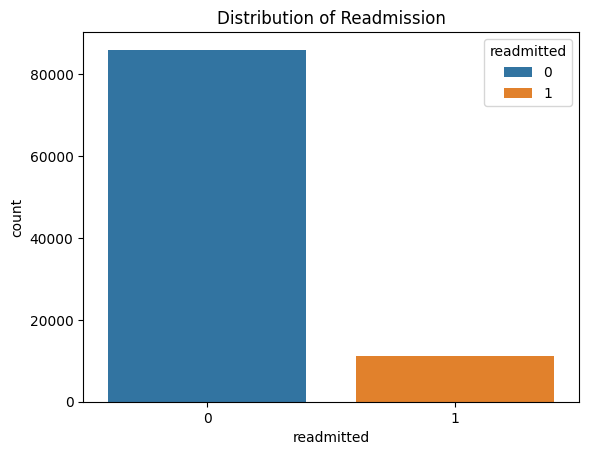

In [81]:
#sns.countplot(target['readmitted']).set_title('Distribution of Readmission')

s = pd.merge(features, target, left_index=True, right_index=True)
sns.countplot(data=s, x='readmitted', hue='readmitted').set_title('Distribution of Readmission')

Text(0.5, 1.0, 'Distribution of Readmission by race')

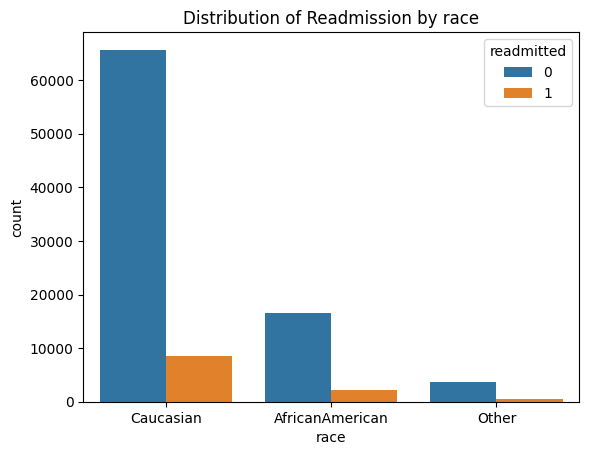

In [82]:
sns.countplot(data=s, x='race', hue='readmitted').set_title('Distribution of Readmission by race')

<ipython-input-83-3811cb89b8f6>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(s.loc[(s['readmitted'] == 0),'time_in_hospital'] , color='b',shade=True,label='Not Readmitted')
<ipython-input-83-3811cb89b8f6>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(s.loc[(s['readmitted'] == 1),'time_in_hospital'] , color='r',shade=True, label='Readmitted')


Text(0.5, 1.0, 'Time in Hospital VS. Readmission')

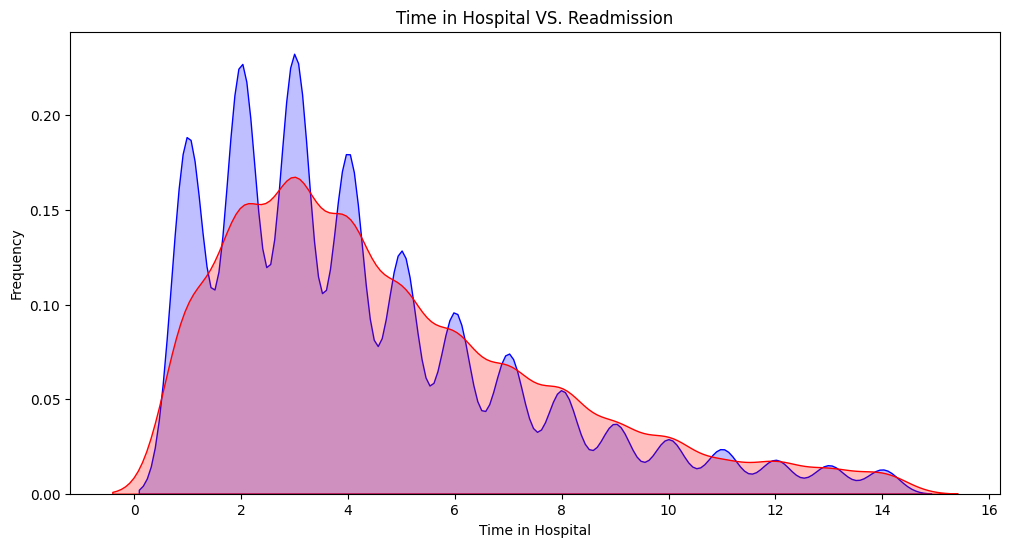

In [83]:

fig = plt.figure(figsize=(12,6),)
ax=sns.kdeplot(s.loc[(s['readmitted'] == 0),'time_in_hospital'] , color='b',shade=True,label='Not Readmitted')
ax=sns.kdeplot(s.loc[(s['readmitted'] == 1),'time_in_hospital'] , color='r',shade=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Frequency')
plt.title('Time in Hospital VS. Readmission')

Text(0.5, 1.0, 'Age of Patient VS. Readmission')

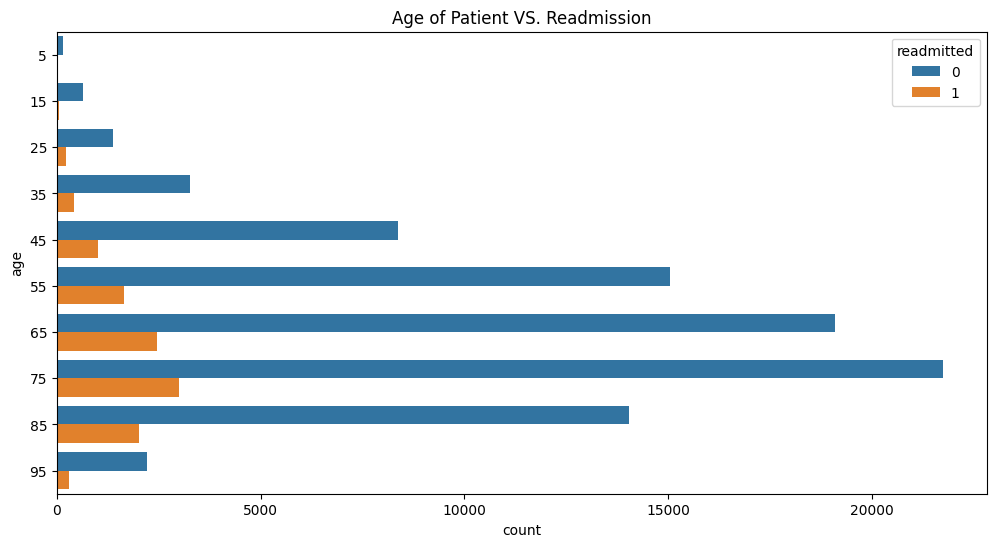

In [84]:
fig = plt.figure(figsize=(12,6))
sns.countplot(y= s['age'], hue = s['readmitted']).set_title('Age of Patient VS. Readmission')

In [85]:
s.select_dtypes(include='number').columns
numerical_columns.extend(['age', 'gender', 'numchange', 'service_util'])
len(numerical_columns)

12

<Axes: xlabel='variable', ylabel='value'>

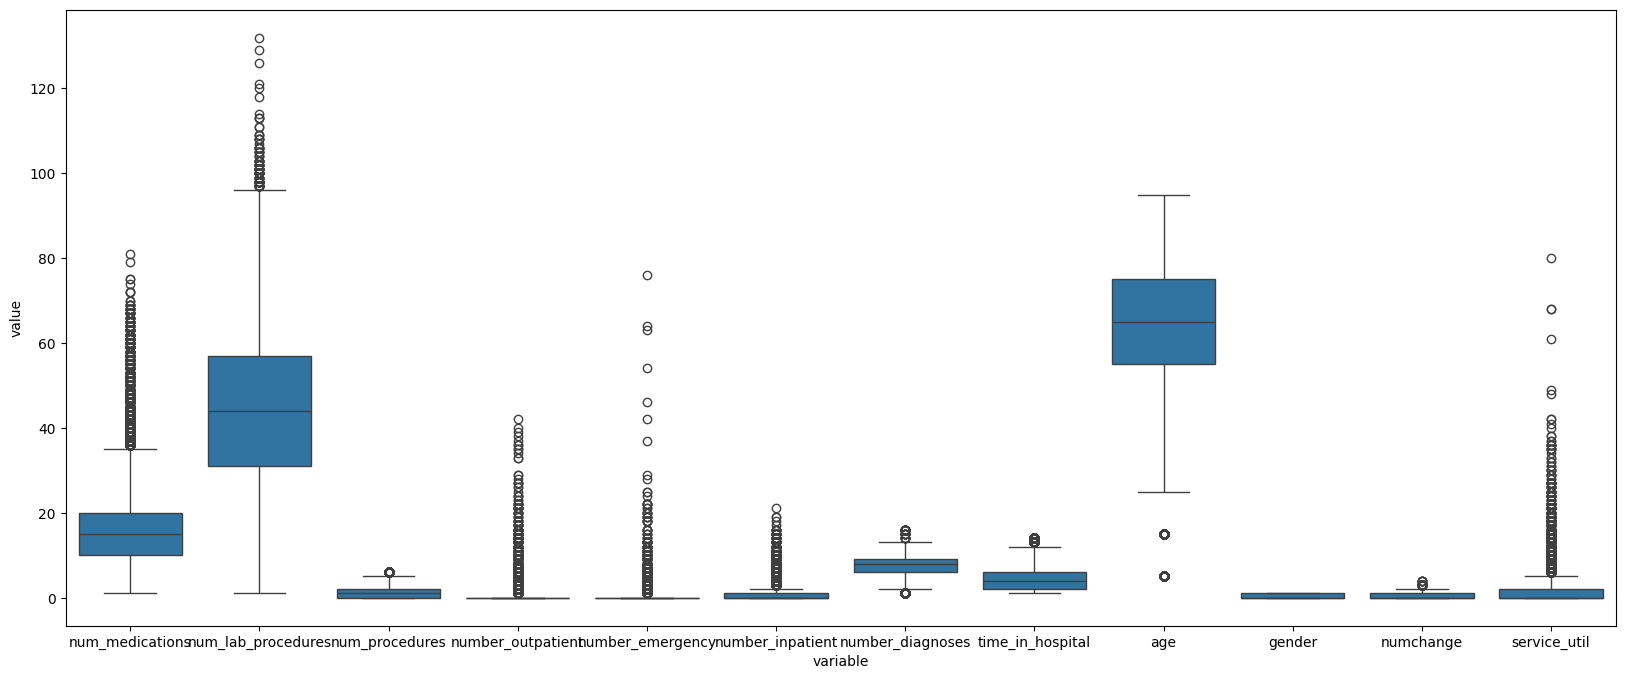

In [86]:
plt.figure(figsize=(20,8))
sns.boxplot(x='variable', y='value', data=pd.melt(s[numerical_columns]))

<Axes: xlabel='variable', ylabel='value'>

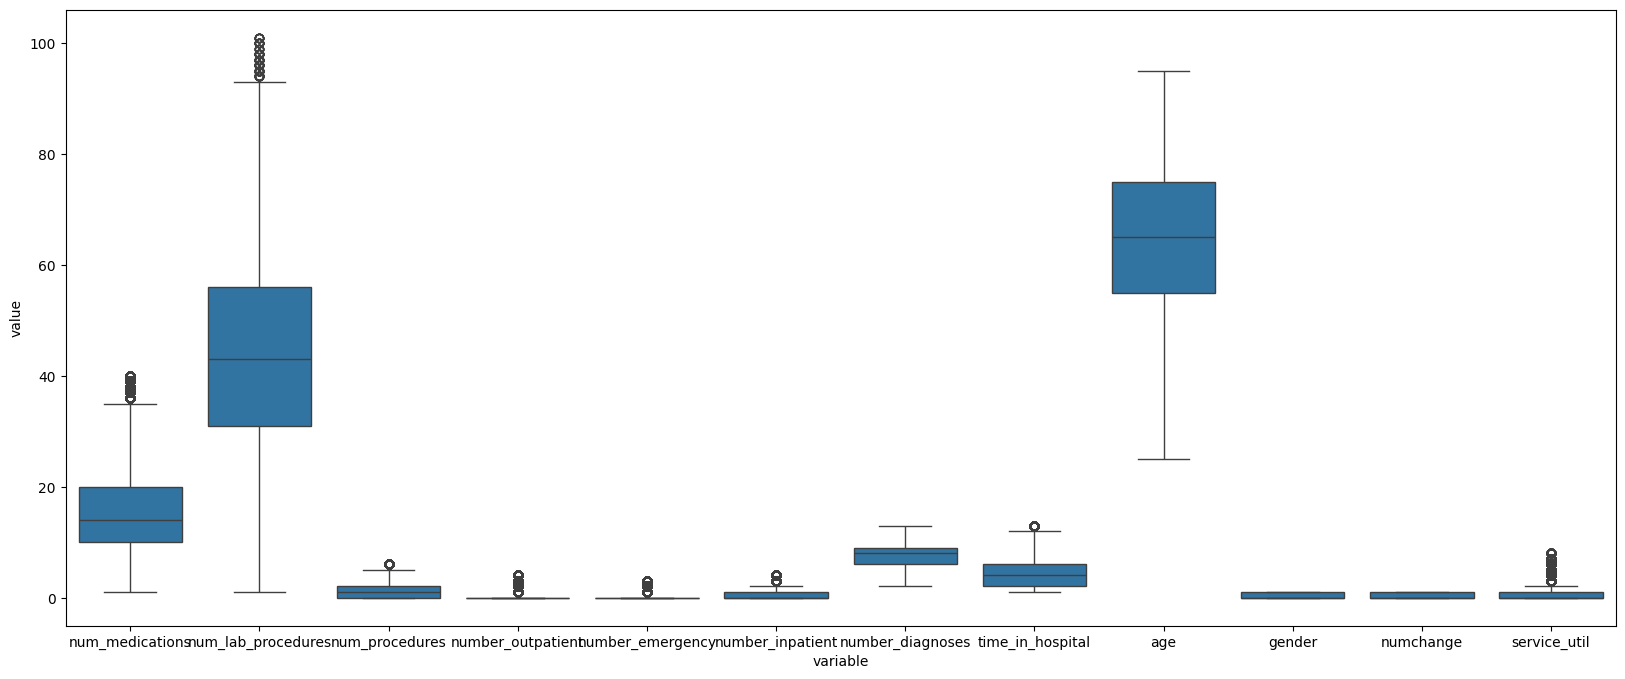

In [87]:
# Remove outliers by only selecting values within 3 standard deviations
q = s[(np.abs(stats.zscore(s[numerical_columns])) < 3).all(axis=1)]
plt.figure(figsize=(20,8))
sns.boxplot(x='variable', y='value', data=pd.melt(q[numerical_columns]))

Text(0.5, 1.0, 'Correlation Heatmap of Numerical Variables')

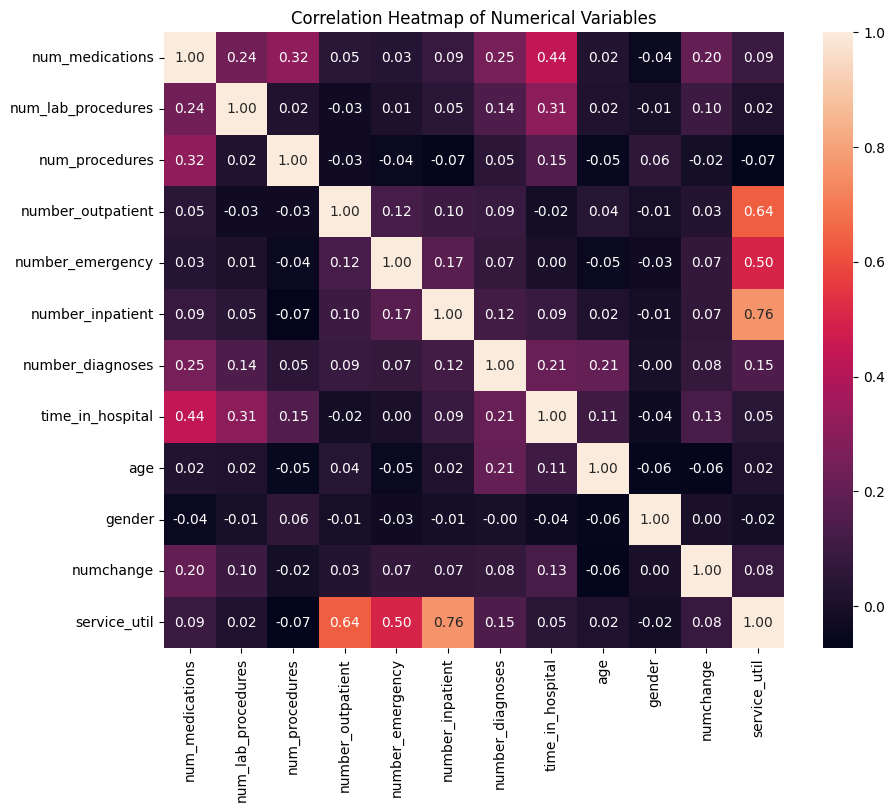

In [88]:
nums = numerical_columns#list(set(q.select_dtypes(include='number').columns).difference(set(medicines)))
plt.figure(figsize=(10,8))
sns.heatmap(q[nums].corr(), annot=True, fmt=".2f")
plt.title("Correlation Heatmap of Numerical Variables")

In [89]:
for col in numerical_columns:
    correl = q['readmitted'].corr(q[col])
    print(col, correl)
print('\n')
for col in numerical_columns:
    correl = q['A1Cresult'].corr(q[col])
    print(col, correl)
print('\n')
for col in numerical_columns:
    correl = q['max_glu_serum'].corr(q[col])
    print(col, correl)

num_medications 0.04458252909119299
num_lab_procedures 0.023941258280954045
num_procedures -0.007746455170407519
number_outpatient 0.018660142879751575
number_emergency 0.038994254850000326
number_inpatient 0.12234465801304402
number_diagnoses 0.05118204077553652
time_in_hospital 0.049769015121523374
age 0.03321338065487571
gender -0.002520599070784764
numchange 0.034270525033316346
service_util 0.10277268902922614


num_medications 0.01956171356537315
num_lab_procedures 0.26205704665172896
num_procedures -0.015124866506272485
number_outpatient -0.03475054283339144
number_emergency -0.010932573795919984
number_inpatient -0.06582183807558445
number_diagnoses 0.008268162982395013
time_in_hospital 0.06554969020818509
age -0.09967034567033846
gender 0.018768149251331412
numchange 0.0945341604242725
service_util -0.06522610346287222


num_medications -0.012834840688976015
num_lab_procedures -0.15766380909859376
num_procedures -0.07858268163718916
number_outpatient 0.08832036016265224
number

<Axes: xlabel='disease', ylabel='count'>

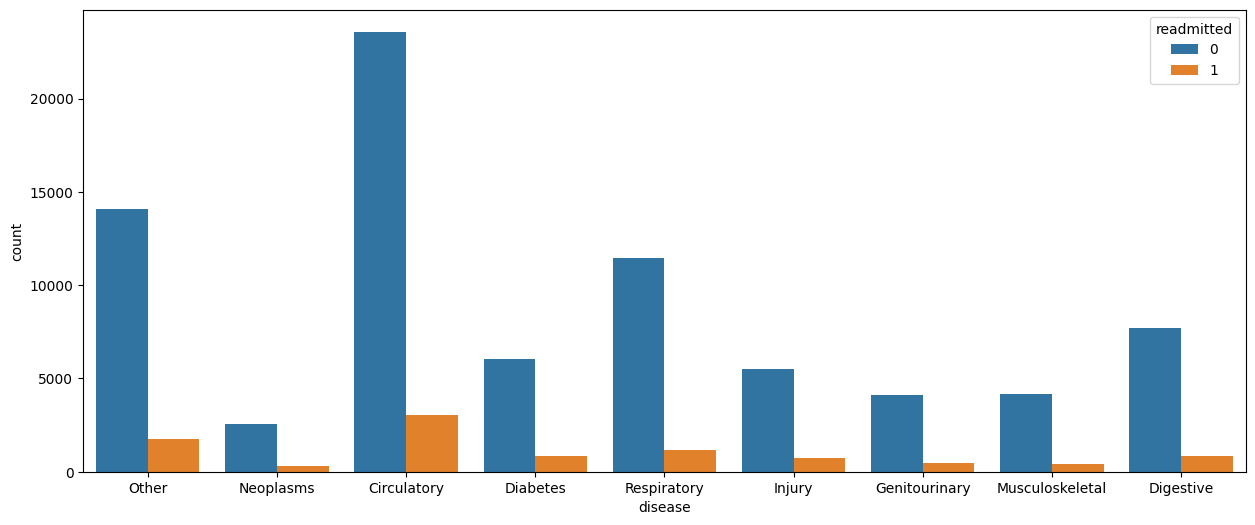

In [90]:
plt.figure(figsize=(15, 6))
sns.countplot(data=q, hue='readmitted', x='disease')

Text(0.5, 1.0, 'Change of Medication VS. Readmission')

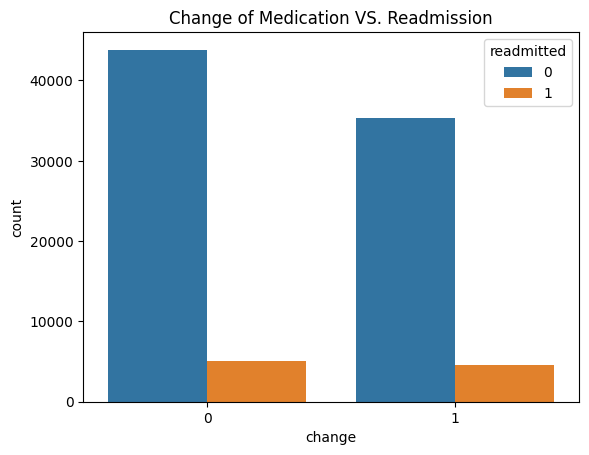

In [91]:
sns.countplot(data=q, x='change', hue ='readmitted').set_title('Change of Medication VS. Readmission')

Text(0.5, 1.0, 'Diabetes Medication prescribed VS Readmission')

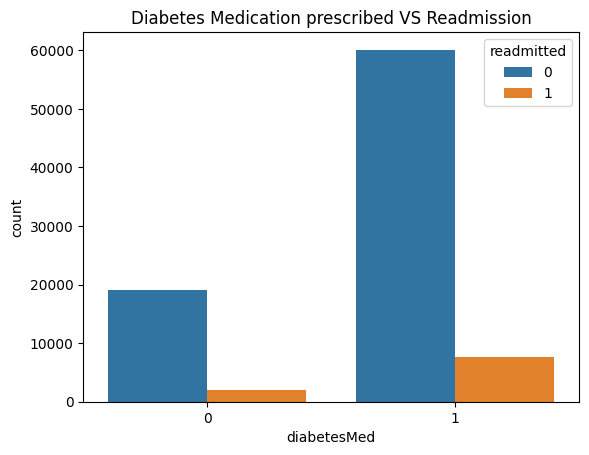

In [92]:
sns.countplot(data=q, x='diabetesMed', hue='readmitted').set_title('Diabetes Medication prescribed VS Readmission')

Text(0.5, 1.0, 'A1C test result VS. Readmission')

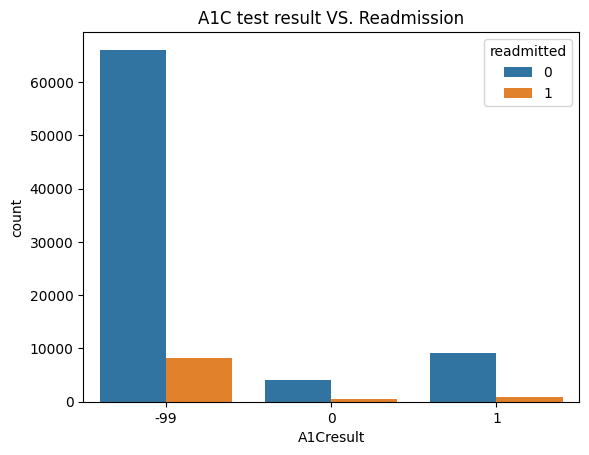

In [93]:
sns.countplot(data=q, x='A1Cresult', hue='readmitted').set_title('A1C test result VS. Readmission')

Text(0.5, 1.0, 'Glucose test serum test result VS. Readmission')

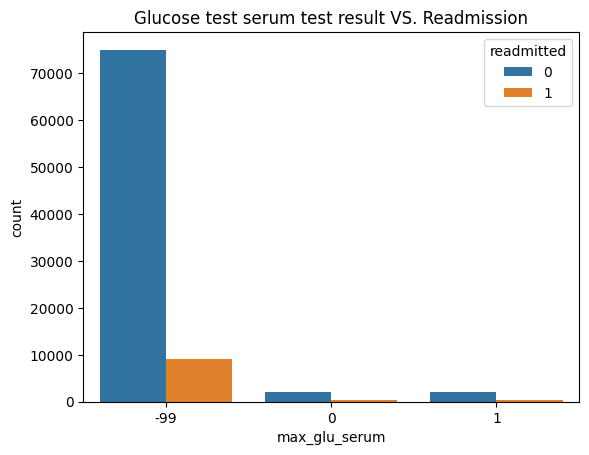

In [94]:
sns.countplot(data=q, x='max_glu_serum', hue='readmitted').set_title('Glucose test serum test result VS. Readmission')

<ipython-input-95-a7a44d5f71ba>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(q.loc[(q['readmitted'] == 0),'num_lab_procedures'] , color='b',shade=True,label='Not readmitted')
<ipython-input-95-a7a44d5f71ba>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(q.loc[(q['readmitted'] == 1),'num_lab_procedures'] , color='r',shade=True, label='readmitted')


Text(0.5, 1.0, 'Number of lab procedure VS. Readmission')

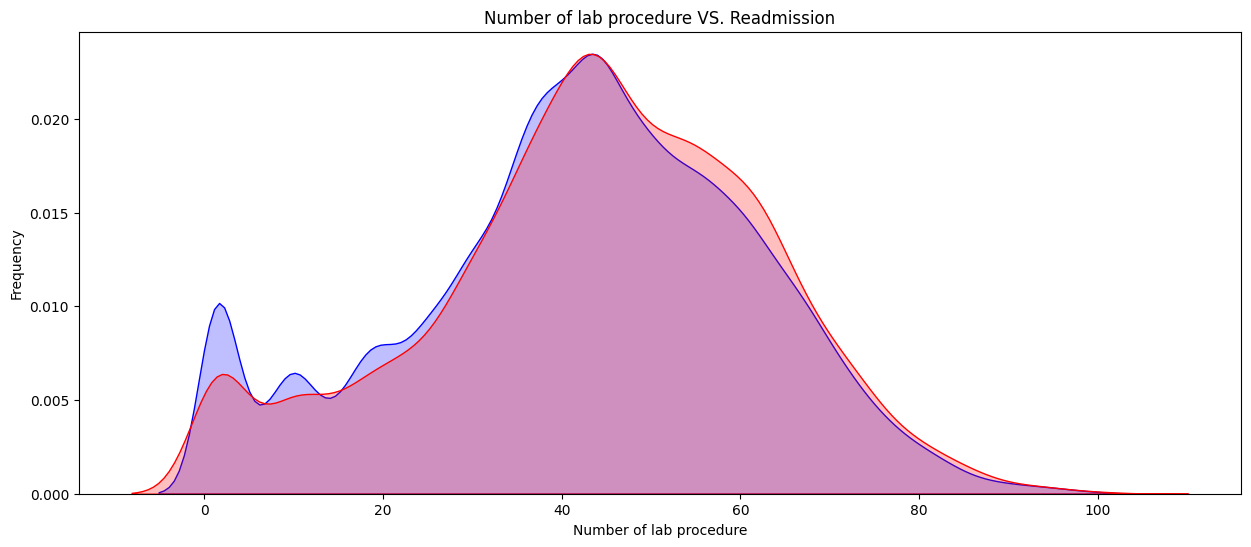

In [95]:
fig = plt.figure(figsize=(15,6),)
ax=sns.kdeplot(q.loc[(q['readmitted'] == 0),'num_lab_procedures'] , color='b',shade=True,label='Not readmitted')
ax=sns.kdeplot(q.loc[(q['readmitted'] == 1),'num_lab_procedures'] , color='r',shade=True, label='readmitted')
ax.set(xlabel='Number of lab procedure', ylabel='Frequency')
plt.title('Number of lab procedure VS. Readmission')

In [96]:
model_colummns = list(q.drop(columns='readmitted').select_dtypes(include='number').columns)
model_colummns

['gender',
 'age',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'discharge_other',
 'admission_elective',
 'admission_emergency',
 'admission_newborn',
 'admission_other',
 'source_emergency room',
 'source_other',
 'source_physician referral',
 'diag_Circulatory',
 'diag_Diabetes',
 'diag_Digestive',
 'diag_Genitourinary',
 'diag_Injury',
 'diag_Musculoskeletal',
 'diag_Neoplasms',
 'diag_Other',
 'diag_Respiratory',
 'numchange',
 

## Preparing Data for Model Training and Evaluation

In this section, we finalize the feature matrix and target vector, scale the data, and split it into training and testing sets.

### Steps:
1. **Feature and Target Selection**:
   - `X_final`: Contains the selected model features defined by `model_colummns`.
   - `y_final`: The target variable indicating whether a patient was readmitted (`readmitted` column).

2. **Data Type Conversion**:
   - Features are cast to `float` for compatibility with machine learning models.
   - The target is cast to `int` since it's a classification task.

3. **Feature Scaling**:
   - Features are standardized using `StandardScaler` so that each feature has mean 0 and standard deviation 1.
   - This is important for algorithms that are sensitive to feature scales (e.g., logistic regression, SVM).

4. **Train-Test Split**:
   - The data is split into training and testing sets using an 80/20 ratio.
   - `stratify=y_final` ensures that both sets maintain the same proportion of class labels as the original dataset.
   - A fixed `random_state` is used for reproducibility.

5. **Distribution Check**:
   - After splitting, we print the shape of the training and test sets, and the distribution of class labels in the training set to ensure stratification worked correctly.


In [97]:
X_final = q[model_colummns]
y_final = q['readmitted']
X_final = X_final.astype(float)
y_final = y_final.astype(int)

scalar = StandardScaler()
X_scaled = scalar.fit_transform(X_final)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_final, test_size=0.2, random_state=2025, stratify=y_final)

print("\nAfter splitting:")
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training target distribution:\n", pd.Series(y_train).value_counts())


After splitting:
Training set shape: (71040, 57)
Test set shape: (17761, 57)
Training target distribution:
 readmitted
0    63335
1     7705
Name: count, dtype: int64


## End-to-End Model Training, Evaluation, and Analysis Pipeline

This section includes the complete workflow for training and evaluating multiple classification models on patient data to predict hospital readmission. It incorporates various preprocessing techniques, resampling strategies to address class imbalance, and feature selection.

---

### 1. Model Training and Evaluation

#### `train_and_evaluate_models(X_train, X_test, y_train, y_test)`
This function trains and evaluates four different classification models:
- **Logistic Regression**
- **Decision Tree**
- **Random Forest**
- **K-Nearest Neighbors**

For each model, it:
- Fits the model on training data.
- Predicts on test data.
- Prints the classification report (precision, recall, f1-score, accuracy).
- Stores performance metrics and predictions in a `results` dictionary.

---

### 2. Evaluation Visualization

#### `plot_conf_matrix(y_true, y_pred, title)`
- Plots the **confusion matrix** for a given set of true and predicted labels using a seaborn heatmap.

#### `plot_model_performance(results, sampling_label="Original")`
- Plots a **bar chart comparing accuracy, precision, and recall** for each model.
- Results are grouped by the sampling technique used (original, oversampled, etc.).

#### `plot_feature_importances(rf_model, feature_names, top_n=15)`
- Extracts and displays the top `n` most important features from a trained Random Forest model using a horizontal bar plot.

---

### 3. Sampling for Imbalanced Classes

Imbalanced classes (e.g., more "not readmitted" than "readmitted") can bias model training. To address this, we apply:

#### `perform_random_oversampling(X_train, y_train)`
- Oversamples the **minority class** by replicating examples until class counts are balanced.

#### `perform_random_undersampling(X_train, y_train)`
- Undersamples the **majority class** by discarding examples to match the minority class count.

---

### 4. Dimensionality Reduction

#### `perform_pca(X_train, X_test, variance_threshold=0.95)`
- Applies **Principal Component Analysis (PCA)** to reduce the feature space while retaining 95% of the data variance.
- Returns transformed training and test sets.

---

### 5. Feature Selection

#### `select_important_features(rf_model, X, top_n=20)`
- Selects the **top `n` most important features** based on the trained Random Forest’s feature importances.
- Helps reduce overfitting and improve model interpretability.

---

### 6. Running the Pipeline

The pipeline is run using four strategies:
1. **Original Data** (no resampling)
2. **Oversampled Data**
3. **Undersampled Data**
4. **Top-N Feature Subset** (based on feature importance)

For each:
- Models are trained and evaluated.
- Performance is plotted.
- Confusion matrices are visualized.

---

### 📌 Conclusion

This complete modeling pipeline provides:
- A comparison of various classifiers.
- An evaluation of the impact of resampling strategies.
- Insight into the most predictive features.
- Multiple ways to improve performance and interpretability.


In [98]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    results = {}

    print("\n--- Logistic Regression ---")
    log_model = LogisticRegression(max_iter=1000, random_state=2025)
    log_model.fit(X_train, y_train)
    y_pred_log = log_model.predict(X_test)
    print("\nLogistic Regression Report:")
    print(classification_report(y_test, y_pred_log))
    results['Logistic Regression'] = {
        'model': log_model,
        'predictions': y_pred_log,
        'report': classification_report(y_test, y_pred_log, output_dict=True)
    }

    # Model B: Decision Tree
    print("\n--- Decision Tree Classifier ---")
    dt_model = DecisionTreeClassifier(max_depth=10, random_state=2025)
    dt_model.fit(X_train, y_train)
    y_pred_dt = dt_model.predict(X_test)
    print("\nDecision Tree Report:")
    print(classification_report(y_test, y_pred_dt))
    results['Decision Tree'] = {
        'model': dt_model,
        'predictions': y_pred_dt,
        'report': classification_report(y_test, y_pred_dt, output_dict=True)
    }

    # Model C: Random Forest
    print("\n--- Random Forest Classifier ---")
    rf_model = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=2025)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    print("\nRandom Forest Report:")
    print(classification_report(y_test, y_pred_rf))
    results['Random Forest'] = {
        'model': rf_model,
        'predictions': y_pred_rf,
        'report': classification_report(y_test, y_pred_rf, output_dict=True)
    }

    # Model D: K-Nearest Neighbors
    print("\n--- K-Nearest Neighbors Classifier ---")
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_test)
    print("\nK-Nearest Neighbors Report:")
    print(classification_report(y_test, y_pred_knn))
    results['K-Nearest Neighbors'] = {
        'model': knn_model,
        'predictions': y_pred_knn,
        'report': classification_report(y_test, y_pred_knn, output_dict=True)
    }

    return results

In [99]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()

In [100]:
def plot_feature_importances(rf_model, feature_names, top_n=15):
    importances = rf_model.feature_importances_
    imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    imp_df = imp_df.sort_values(by="Importance", ascending=False).head(top_n)
    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature", data=imp_df, palette="viridis")
    plt.title("Top {} Feature Importances from Random Forest".format(top_n))
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

In [101]:
def plot_model_performance(results, sampling_label="Original"):
    metrics = {"Model": [], "Accuracy": [], "Precision": [], "Recall": []}
    for model_name, result in results.items():
        rep = result["report"]
        metrics["Model"].append(model_name)
        metrics["Accuracy"].append(rep["accuracy"])
        metrics["Precision"].append(rep["1"]["precision"])
        metrics["Recall"].append(rep["1"]["recall"])
    df_metrics = pd.DataFrame(metrics)
    df_metrics.set_index("Model", inplace=True)

    df_metrics.plot(kind="bar", figsize=(10,6))
    plt.title(f"Performance Comparison of Models ({sampling_label} Sampling)")
    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.ylim(0,1)
    plt.legend(loc="lower right")
    plt.show()
    return df_metrics

In [102]:
def perform_random_oversampling(X_train, y_train):
    ros = RandomOverSampler(random_state=2025)
    X_train_over, y_train_over = ros.fit_resample(X_train, y_train)
    print("\nAfter Random Oversampling (minority counts):", np.bincount(y_train_over))
    return X_train_over, y_train_over

def perform_random_undersampling(X_train, y_train):
    rus = RandomUnderSampler(random_state=2025)
    X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
    print("\nAfter Random Undersampling (majority counts):", np.bincount(y_train_under))
    return X_train_under, y_train_under

In [103]:
def select_important_features(rf_model, X, top_n=20):
    importances = rf_model.feature_importances_
    feat_df = pd.DataFrame({"Feature": X.columns, "Importance": importances})
    feat_df = feat_df.sort_values(by="Importance", ascending=False).head(top_n)
    important_features = feat_df["Feature"].tolist()
    print("\nSelected important features:", important_features)
    return important_features

In [104]:
def perform_pca(X_train, X_test, variance_threshold=0.95):
    """
    Fit PCA on the training set to retain a specified amount of variance,
    then transform both training and test sets.
    """
    pca = PCA(n_components=variance_threshold, random_state=2025)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    print(f"\nPCA reduced the feature set from {X_train.shape[1]} to {X_train_pca.shape[1]} components.")
    return X_train_pca, X_test_pca, pca


PCA reduced the feature set from 57 to 43 components.

--- Modeling on Original Data (No Resampling) ---

--- Logistic Regression ---

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     15835
           1       0.00      0.00      0.00      1926

    accuracy                           0.89     17761
   macro avg       0.45      0.50      0.47     17761
weighted avg       0.79      0.89      0.84     17761


--- Decision Tree Classifier ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Decision Tree Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     15835
           1       0.21      0.01      0.02      1926

    accuracy                           0.89     17761
   macro avg       0.55      0.50      0.48     17761
weighted avg       0.82      0.89      0.84     17761


--- Random Forest Classifier ---

Random Forest Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     15835
           1       1.00      0.00      0.00      1926

    accuracy                           0.89     17761
   macro avg       0.95      0.50      0.47     17761
weighted avg       0.90      0.89      0.84     17761


--- K-Nearest Neighbors Classifier ---

K-Nearest Neighbors Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     15835
           1       0.18      0.02      0.04      1926

    accuracy                     

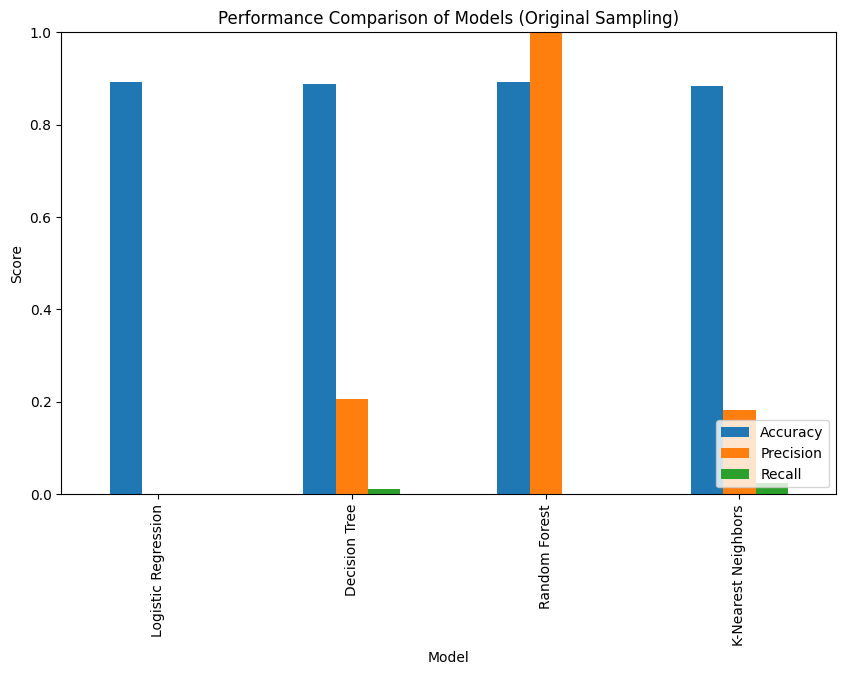

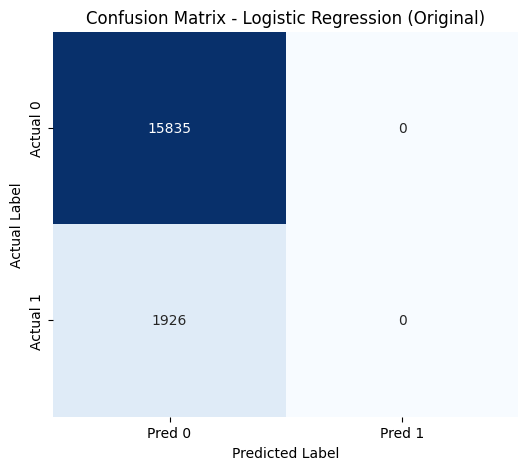

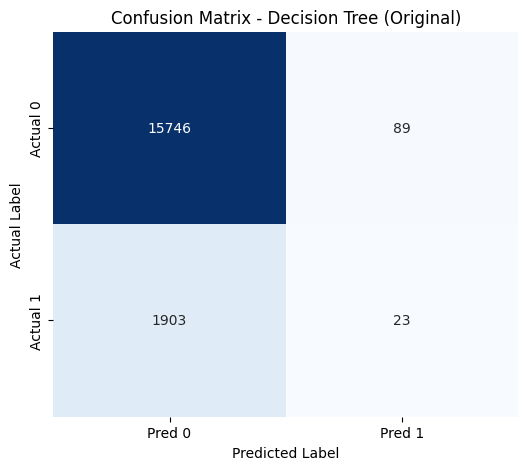

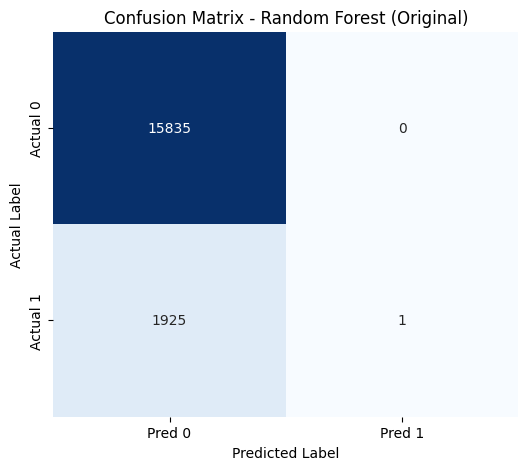

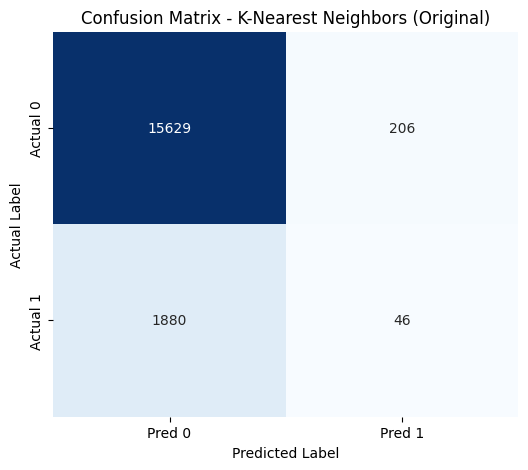


After Random Oversampling (minority counts): [63335 63335]

--- Modeling on Oversampled Data ---

--- Logistic Regression ---

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.92      0.64      0.76     15835
           1       0.16      0.57      0.25      1926

    accuracy                           0.63     17761
   macro avg       0.54      0.60      0.50     17761
weighted avg       0.84      0.63      0.70     17761


--- Decision Tree Classifier ---

Decision Tree Report:
              precision    recall  f1-score   support

           0       0.92      0.56      0.70     15835
           1       0.14      0.59      0.23      1926

    accuracy                           0.57     17761
   macro avg       0.53      0.58      0.46     17761
weighted avg       0.83      0.57      0.65     17761


--- Random Forest Classifier ---

Random Forest Report:
              precision    recall  f1-score   support

           0       0.

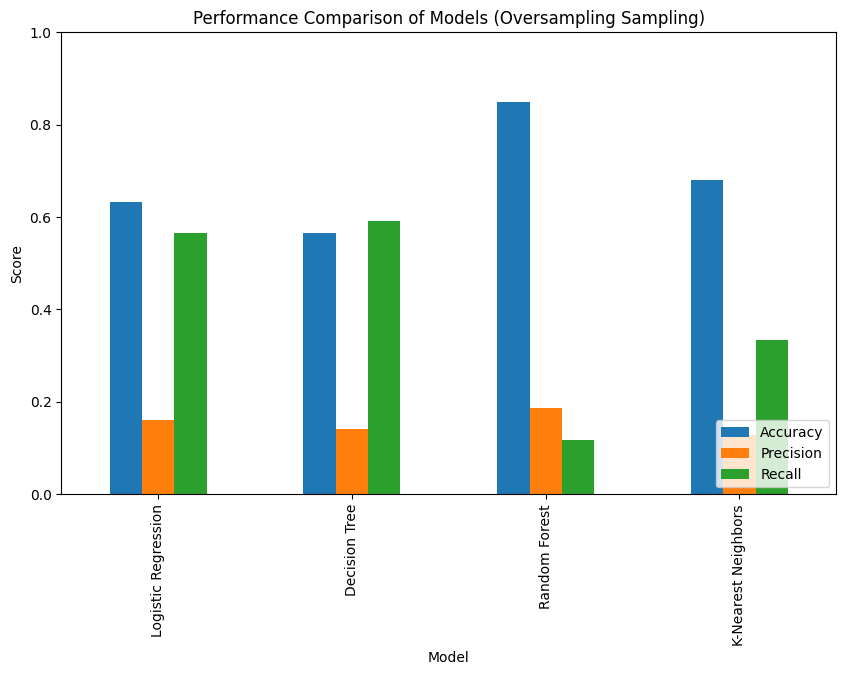

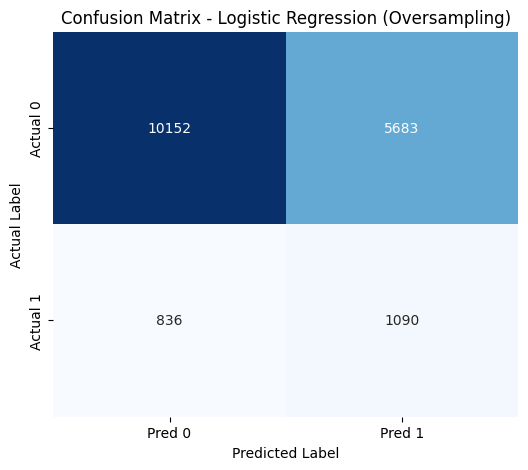

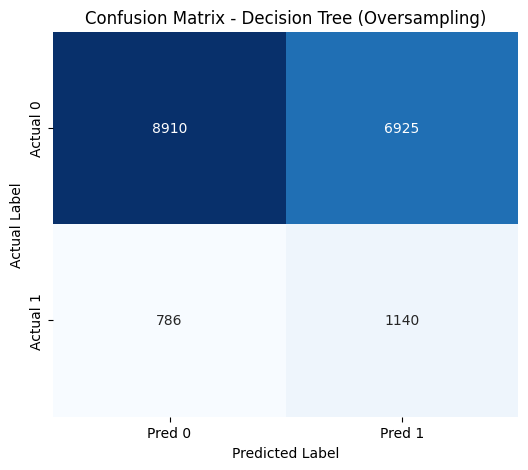

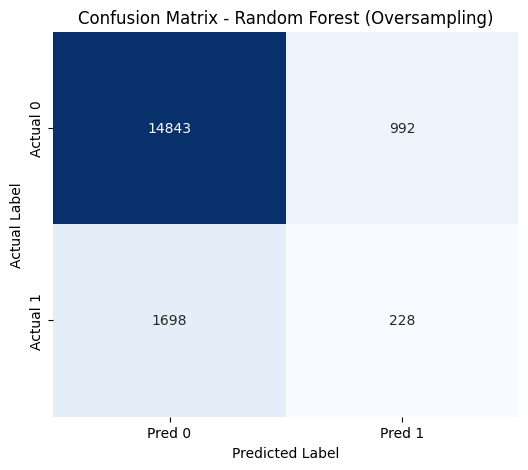

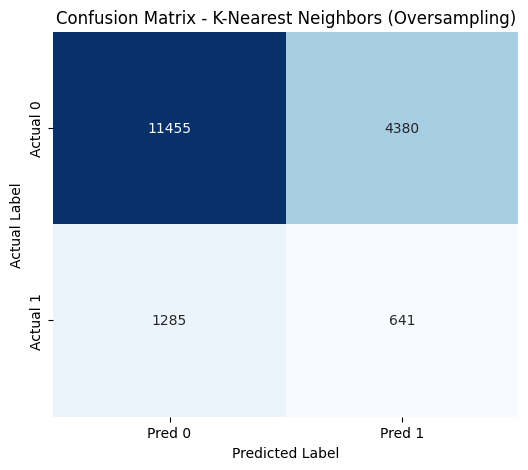


After Random Undersampling (majority counts): [7705 7705]

--- Modeling on Undersampled Data ---

--- Logistic Regression ---

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.92      0.63      0.75     15835
           1       0.16      0.56      0.25      1926

    accuracy                           0.63     17761
   macro avg       0.54      0.60      0.50     17761
weighted avg       0.84      0.63      0.70     17761


--- Decision Tree Classifier ---

Decision Tree Report:
              precision    recall  f1-score   support

           0       0.91      0.54      0.68     15835
           1       0.13      0.55      0.21      1926

    accuracy                           0.54     17761
   macro avg       0.52      0.55      0.44     17761
weighted avg       0.82      0.54      0.63     17761


--- Random Forest Classifier ---

Random Forest Report:
              precision    recall  f1-score   support

           0       0.

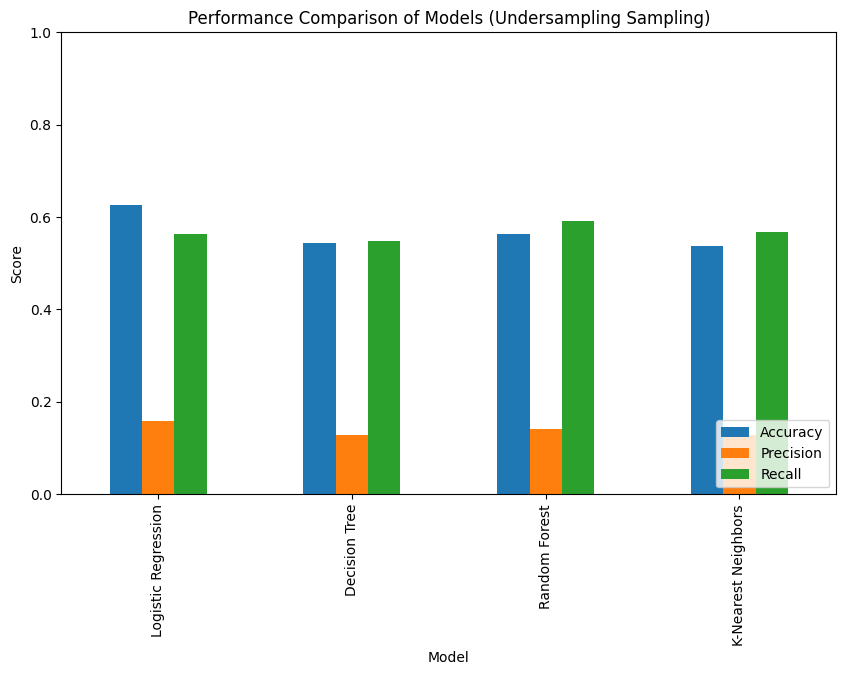

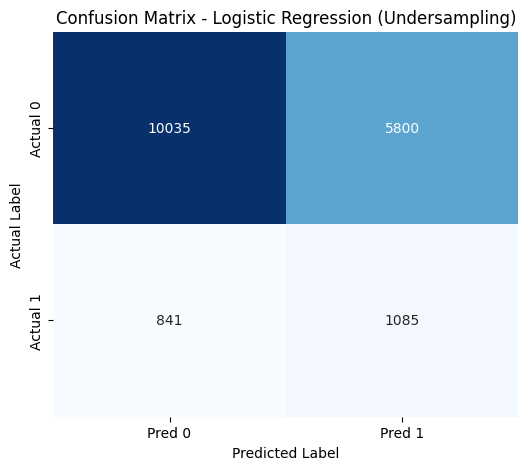

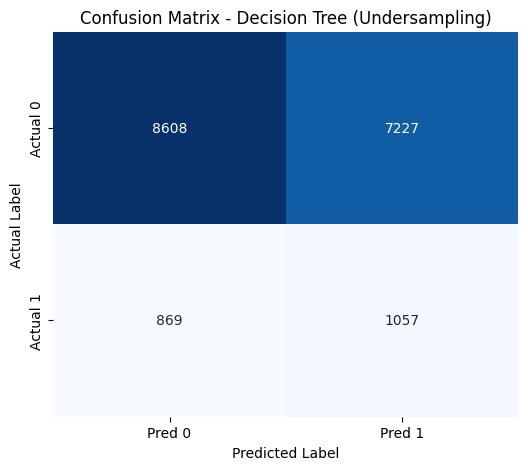

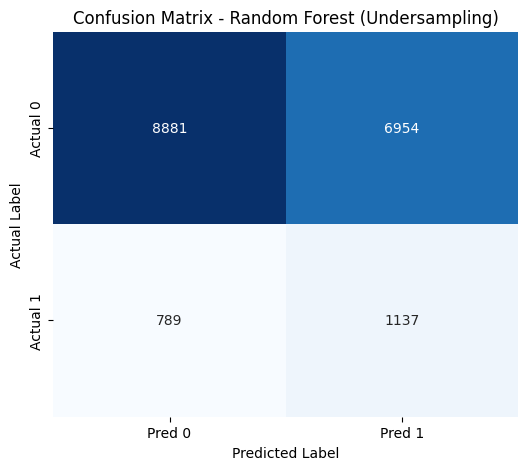

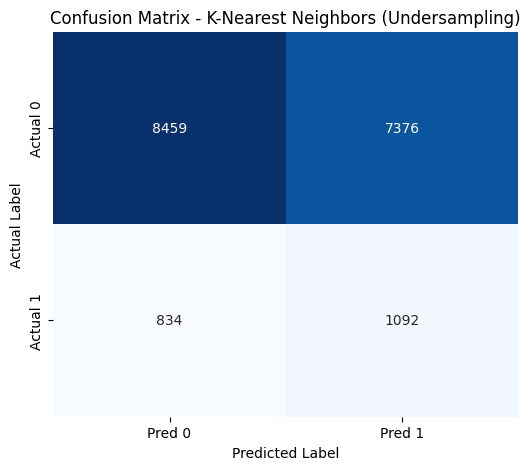


--- Feature Subset Modeling ---

Selected important features: ['num_lab_procedures', 'num_medications', 'time_in_hospital', 'age', 'num_procedures', 'number_diagnoses', 'service_util', 'number_inpatient', 'gender', 'A1Cresult', 'number_outpatient', 'insulin', 'source_emergency room', 'number_emergency', 'Caucasian', 'diag_Circulatory', 'source_physician referral', 'change', 'metformin', 'admission_emergency']

--- Logistic Regression ---

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     15835
           1       0.00      0.00      0.00      1926

    accuracy                           0.89     17761
   macro avg       0.45      0.50      0.47     17761
weighted avg       0.79      0.89      0.84     17761


--- Decision Tree Classifier ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Decision Tree Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     15835
           1       0.22      0.01      0.02      1926

    accuracy                           0.89     17761
   macro avg       0.56      0.50      0.48     17761
weighted avg       0.82      0.89      0.84     17761


--- Random Forest Classifier ---

Random Forest Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     15835
           1       0.18      0.00      0.00      1926

    accuracy                           0.89     17761
   macro avg       0.54      0.50      0.47     17761
weighted avg       0.81      0.89      0.84     17761


--- K-Nearest Neighbors Classifier ---

K-Nearest Neighbors Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     15835
           1       0.16      0.02      0.03      1926

    accuracy                     

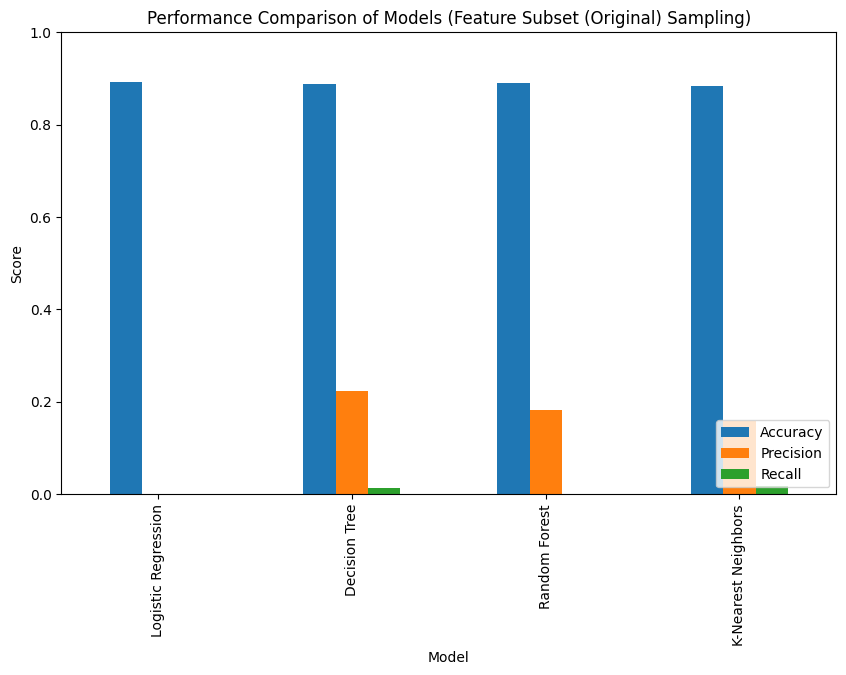

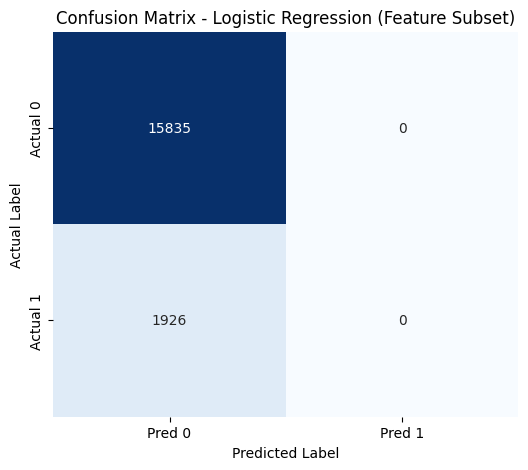

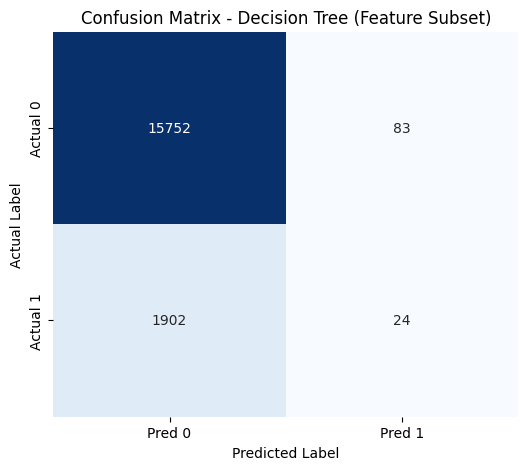

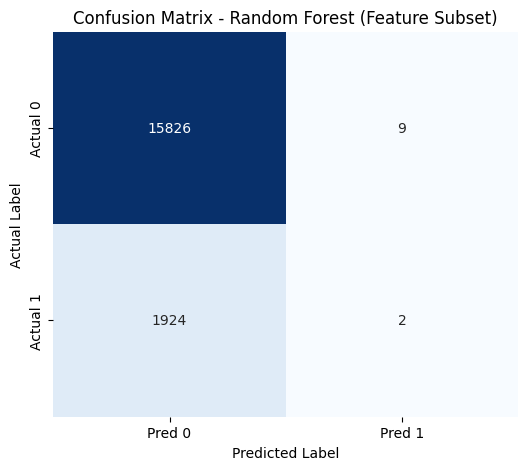

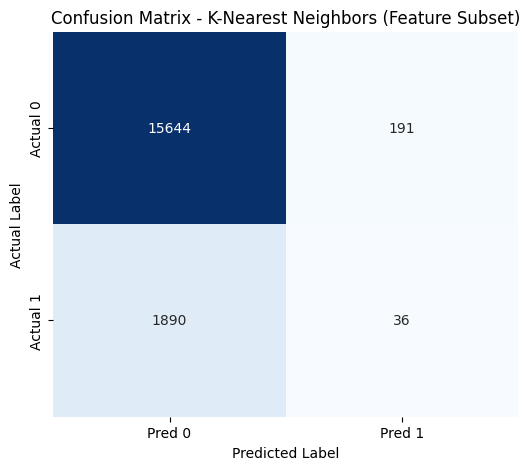

<ipython-input-100-6ceb54db60f7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=imp_df, palette="viridis")


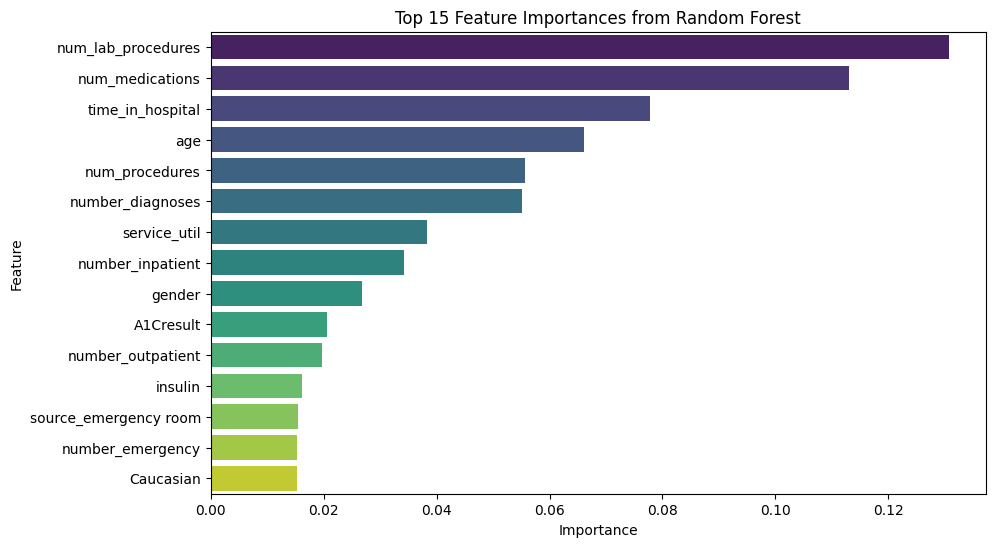

In [105]:
feat_names = X_final.columns

X_train_pca, X_test_pca, pca = perform_pca(X_train, X_test, variance_threshold=0.95)

# Train and evaluate models on the original (imbalanced) data.
print("\n--- Modeling on Original Data (No Resampling) ---")
results_original = train_and_evaluate_models(X_train, X_test, y_train, y_test)
plot_model_performance(results_original, sampling_label="Original")
for model_name, result in results_original.items():
    plot_conf_matrix(y_test, result['predictions'], f"Confusion Matrix - {model_name} (Original)")

# Train and evaluate models on oversampled data.
X_train_over, y_train_over = perform_random_oversampling(X_train, y_train)
print("\n--- Modeling on Oversampled Data ---")
results_over = train_and_evaluate_models(X_train_over, X_test, y_train_over, y_test)
plot_model_performance(results_over, sampling_label="Oversampling")
for model_name, result in results_over.items():
    plot_conf_matrix(y_test, result['predictions'], f"Confusion Matrix - {model_name} (Oversampling)")

# Train and evaluate models on undersampled data.
X_train_under, y_train_under = perform_random_undersampling(X_train, y_train)
print("\n--- Modeling on Undersampled Data ---")
results_under = train_and_evaluate_models(X_train_under, X_test, y_train_under, y_test)
plot_model_performance(results_under, sampling_label="Undersampling")
for model_name, result in results_under.items():
    plot_conf_matrix(y_test, result['predictions'], f"Confusion Matrix - {model_name} (Undersampling)")

# Using the original data, select important features based on Random Forest importance,
# then re-run modeling using only this subset.
print("\n--- Feature Subset Modeling ---")
rf_model_original = results_original['Random Forest']['model']
important_feats = select_important_features(rf_model_original, pd.DataFrame(X_train, columns=feat_names), top_n=20)
# Reduce original X datasets to selected features.
X_train_subset = pd.DataFrame(X_train, columns=feat_names)[important_feats].values
X_test_subset = pd.DataFrame(X_test, columns=feat_names)[important_feats].values
results_subset = train_and_evaluate_models(X_train_subset, X_test_subset, y_train, y_test)
plot_model_performance(results_subset, sampling_label="Feature Subset (Original)")
for model_name, result in results_subset.items():
    plot_conf_matrix(y_test, result['predictions'], f"Confusion Matrix - {model_name} (Feature Subset)")

# Plot feature importances from the original Random Forest.
plot_feature_importances(rf_model_original, feat_names, top_n=15)


In [106]:
print("""
    ===== Conclusion =====
    In this extended analysis, we built an end-to-end pipeline to predict early hospital readmission
    (within 30 days) for diabetic patients, following these key steps:
      • Data cleaning and transformation based on specified rules:
            - Dropping 'weight', 'payer_code', and 'medical_specialty' (due to high missingness).
            - Removing encounter id while retaining patient number, then dropping duplicate encounters.
            - Considering only the primary diagnosis, dropping extraneous medication columns, and
              omitting rows with missing values in race, gender, or diag_1.
            - Processing discharge disposition, admission type, and admission source as per specified rules.
            - Mapping diag_1 into disease categories and one-hot encoding the results.
            - One-hot encoding age groups and renaming A1Cresult to HbA1c.
            - Removing outliers in continuous variables.
      • Extensive EDA to explore variable distributions and relationships.
      • Dimensionality reduction with PCA was applied to reduce feature dimensionality while preserving 95% of variance.
      • Model training for four algorithms under three sampling strategies:
            - Original imbalanced data.
            - Random oversampling of the minority class.
            - Random undersampling of the majority class.
      • Performance comparison via classification reports, confusion matrices,
        and a bar chart comparing Accuracy, Precision, and Recall.
      • Feature importance analysis using Random Forest and re-running models using the selected subset.

    Random Forest consistently demonstrated robust performance, indicating the critical importance of
    factors such as time in hospital, number of diagnoses, and key encoded features.

    Future work may include exploring more advanced resampling methods (e.g., SMOTE), further feature engineering,
    and hyperparameter tuning to further improve prediction performance.

    This project illustrates the practical application of data science techniques in addressing a significant
    healthcare challenge.
    """)


    ===== Conclusion =====
    In this extended analysis, we built an end-to-end pipeline to predict early hospital readmission
    (within 30 days) for diabetic patients, following these key steps:
      • Data cleaning and transformation based on specified rules:
            - Dropping 'weight', 'payer_code', and 'medical_specialty' (due to high missingness).
            - Removing encounter id while retaining patient number, then dropping duplicate encounters.
            - Considering only the primary diagnosis, dropping extraneous medication columns, and
              omitting rows with missing values in race, gender, or diag_1.
            - Processing discharge disposition, admission type, and admission source as per specified rules.
            - Mapping diag_1 into disease categories and one-hot encoding the results.
            - One-hot encoding age groups and renaming A1Cresult to HbA1c.
            - Removing outliers in continuous variables.
      • Extensive EDA to expl